# Prediction of COVID-19 Around the World

| Student | __Angela Amador__ |
| ------ | ----- |
| TMU Student Number | __500259095__ |
| Supervisor | __Tamer Abdou, PhD__  |

I aim to demonstrate how Machine Learning (ML) models were able to predict the spread of COVID-19 around the world.

First, I will explore the dataset to get insights and better understand patterns, detect error and outliers, and find relationships between variables.

## Preparation

The dataset is taken from Our World in Data website, officially collected by Our World in Data team: https://covid.ourworldindata.org/data/owid-covid-data.csv.

The dataset, provides COVID-19 information collected by [Our World in Data](https://www.kaggle.com/datasets/caesarmario/our-world-in-data-covid19-dataset) and made available by the Kaggle community https://www.kaggle.com/datasets/caesarmario/our-world-in-data-covid19-dataset/download?datasetVersionNumber=418. This dataset is updated daily.

In [1]:
import warnings

# Use jupyter_black to automatically format the code
import black
import jupyter_black
import matplotlib.pyplot as plt
import numpy as np

# Import libraries
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import Markdown, display
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, VarianceThreshold, chi2
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.svm import SVC
from ydata_profiling import ProfileReport


jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="INFO",
    target_version=black.TargetVersion.PY310,
)

# Use pycodestyle to enforce coding standards.
%load_ext pycodestyle_magic
%pycodestyle_on

warnings.filterwarnings("ignore")
InteractiveShell.ast_node_interactivity = "all"

<IPython.core.display.Javascript object>

### Load file and explore data

For the purpose of this study I am analyzing the data with information up to Oct 7th, 2023.

In [2]:
# Load file
raw_data = pd.read_csv("archive.zip", sep=",")

# Explore data
raw_data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN


### Check the data type and metadata of the attributes

In [3]:
# look at meta information about data, such as data types and null values
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346567 entries, 0 to 346566
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    346567 non-null  object 
 1   continent                                   330089 non-null  object 
 2   location                                    346567 non-null  object 
 3   date                                        346567 non-null  object 
 4   total_cases                                 308672 non-null  float64
 5   new_cases                                   337028 non-null  float64
 6   new_cases_smoothed                          335769 non-null  float64
 7   total_deaths                                287169 non-null  float64
 8   new_deaths                                  337072 non-null  float64
 9   new_deaths_smoothed                         335842 non-null  float64
 

Look at meta information about numeric data, we can also see if there any
extreme values.

In [4]:
raw_data.describe()

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
count,3.086720e+05,3.370280e+05,3.357690e+05,2.871690e+05,337072.000000,335842.000000,308672.000000,337028.000000,335769.000000,287169.000000,...,198833.000000,131627.000000,237221.000000,318823.000000,260466.000000,3.465670e+05,1.195300e+04,11953.000000,11953.000000,11953.000000
mean,6.609069e+06,9.695906e+03,9.732069e+03,8.559525e+04,86.392889,86.704207,100634.394008,146.569024,147.113196,867.354640,...,32.909864,50.789455,3.097109,73.714185,0.722460,1.283225e+08,5.113535e+04,9.739424,11.461129,1646.844959
std,4.032547e+07,1.108324e+05,9.495414e+04,4.380493e+05,616.815791,561.926045,150292.226515,1169.506821,602.840371,1096.750172,...,13.574185,31.956355,2.548353,7.395560,0.148979,6.603117e+08,1.442796e+05,12.380781,25.354695,1929.159161
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,7.700000,1.188000,0.100000,53.280000,0.394000,4.700000e+01,-3.772610e+04,-44.230000,-95.920000,-2752.924800
25%,7.988750e+03,0.000000e+00,2.860000e-01,1.250000e+02,0.000000,0.000000,2573.783500,0.000000,0.056000,59.672000,...,22.600000,20.859000,1.300000,69.590000,0.602000,4.490020e+05,1.066000e+02,1.320000,-1.620000,65.345720
50%,6.904700e+04,2.000000e+00,2.585700e+01,1.313000e+03,0.000000,0.143000,27720.494000,0.169000,6.815000,374.322000,...,33.100000,49.839000,2.500000,75.050000,0.740000,5.882259e+06,5.736601e+03,8.070000,5.770000,1072.472700
75%,7.345502e+05,2.730000e+02,5.107140e+02,1.181800e+04,3.000000,5.286000,131483.602000,36.566000,84.076000,1356.019000,...,41.300000,82.502000,4.200000,79.460000,0.829000,2.830170e+07,3.668959e+04,15.470000,16.520000,2704.933800
max,7.711505e+08,8.401961e+06,6.402036e+06,6.960770e+06,27939.000000,14821.857000,737554.506000,228872.025000,37241.781000,6511.209000,...,78.100000,100.000000,13.800000,86.750000,0.957000,7.975105e+09,1.289776e+06,76.550000,377.630000,10292.916000


Helper function to generate a markdown table with details of a dataframe.

In [5]:
def df_details(label, df):
    """ Generate a markdown table with details of a dataframe """
    display(
        Markdown(
            rf"""
| {label} | |
| --- | ---: |
| Number of observations | {df.shape[0]} |
| Number of attributes | {df.shape[1]} |
| Size | {df.size} |
"""
        )
    )


df_details("Original dataset", raw_data)


| Original dataset | |
| --- | ---: |
| Number of observations | 346567 |
| Number of attributes | 67 |
| Size | 23219989 |


### One Hot Encoding in Machine Learning

Machine Learning models do not work with categorical data and to fit this data into the machine learning model it needs to be converted into numerical data. One technique is to use One Hot Encoding technique. One hot encoding is a technique that we use to represent categorical variables as numerical values in a machine learning model.

We have four catgorical variables in the dataset: iso_code, continent, location and tests_units.

In [6]:
print("Describe categorical variables")
print("\niso_code:")
raw_data['iso_code'].describe(include='all')
print("\ncontinent:")
raw_data['continent'].describe(include='all')
print("\nlocation:")
raw_data['location'].describe(include='all')
print("\ntests_units:")
raw_data['tests_units'].describe(include='all')

Describe categorical variables

iso_code:


count     346567
unique       255
top          ARG
freq        1375
Name: iso_code, dtype: object


continent:


count     330089
unique         6
top       Africa
freq       78148
Name: continent, dtype: object


location:


count        346567
unique          255
top       Argentina
freq           1375
Name: location, dtype: object


tests_units:


count              106788
unique                  4
top       tests performed
freq                80099
Name: tests_units, dtype: object

#### Create New DataFrame
Now, for using categorical variables we will create a new dataframe of selected categorical columns.

In [7]:
categorical_cols = ['iso_code', 'continent', 'location', 'tests_units']
categorical_df = raw_data[categorical_cols]
categorical_df.head()

,iso_code,continent,location,tests_units
0,AFG,Asia,Afghanistan,NaN
1,AFG,Asia,Afghanistan,NaN
2,AFG,Asia,Afghanistan,NaN
3,AFG,Asia,Afghanistan,NaN
4,AFG,Asia,Afghanistan,NaN


#### Finding Unique Values

For finding unique values we will use pandas unique() function.

In [8]:
# unique values in each columns
for x in categorical_df.columns:
    print(x, ':', len(categorical_df[x].unique()))

iso_code : 255
continent : 7
location : 255
tests_units : 5


Examine How many columns we will obatain after one hot encoding these variables

In [9]:
pd.get_dummies(categorical_df, drop_first=False).shape

(346567, 520)

Apply One Hot Encoding to all 4 categorical variables: 'iso_code', 'continent', 'location' and 'tests_units'

In [36]:
# One-hot encoding
encoder = OneHotEncoder(sparse_output=False)

raw_data_cols = raw_data.shape[1]

# One-hot encoding 'iso_code' column
origin_encoded = encoder.fit_transform(raw_data[['iso_code']])
df_encoded = pd.concat([
    raw_data,
    pd.DataFrame(origin_encoded, columns=encoder.categories_[0])
    ], axis=1)

# df_encoded.head()

if df_encoded.columns.is_unique is False:
    # print('\nDuplicate columns after iso_code encoding\n')
    duplicate_cols = df_encoded.columns[df_encoded.columns.duplicated()]
    df_encoded.drop(columns=duplicate_cols, inplace=True)

df_encoded_iso_code = df_encoded.shape[1]

df_details("\nAfter One hot encoding: iso_code", df_encoded)

# One-hot encoding 'continent' column
origin_encoded = encoder.fit_transform(raw_data[['continent']])

df_encoded = pd.concat([
    df_encoded,
    pd.DataFrame(origin_encoded, columns=encoder.categories_[0])
    ], axis=1)

# Continent created a column NaN at the end, eliminating this column
df_encoded = df_encoded.iloc[:, :-1]

if df_encoded.columns.is_unique is False:
    # print('\nDuplicate columns after continent encoding\n')
    duplicate_cols = df_encoded.columns[df_encoded.columns.duplicated()]
    df_encoded.drop(columns=duplicate_cols, inplace=True)

df_encoded_continent = df_encoded.shape[1]

df_details("\nAfter One hot encoding: continent", df_encoded)

# One-hot encoding 'location' column
origin_encoded = encoder.fit_transform(df_encoded[['location']])
df_encoded = pd.concat([
    df_encoded,
    pd.DataFrame(origin_encoded, columns=encoder.categories_[0])
    ], axis=1)

# location created a column NaN at the end, eliminating this column
df_encoded = df_encoded.iloc[:, :-1]

if df_encoded.columns.is_unique is False:
    # print('\nDuplicate columns after location encoding\n')
    duplicate_cols = df_encoded.columns[df_encoded.columns.duplicated()]
    df_encoded.drop(columns=duplicate_cols, inplace=True)

df_encoded_location = df_encoded.shape[1]

df_details("\nAfter One hot encoding: location", df_encoded)

# One-hot encoding 'tests_units' column
origin_encoded = encoder.fit_transform(df_encoded[['tests_units']])
df_encoded = pd.concat([
    df_encoded,
    pd.DataFrame(origin_encoded, columns=encoder.categories_[0])
    ], axis=1)

# set the max columns to none
# pd.set_option('display.max_columns', None)

# tests_units created a column NaN at the end, eliminating this column
df_encoded = df_encoded.iloc[:, :-1]

if df_encoded.columns.is_unique is False:
    # print('\nDuplicate columns after tests_units encoding\n')
    duplicate_cols = df_encoded.columns[df_encoded.columns.duplicated()]
    df_encoded.drop(columns=duplicate_cols, inplace=True)

df_encoded_tests_units = df_encoded.shape[1]
df_details("\nAfter One hot encoding: tests_units", df_encoded)
# df_encoded.columns
# df_encoded.columns[-10:]
# df_encoded.info()
# list(df_encoded.columns)
# list(pd.get_dummies(categorical_df, drop_first=True).columns)
df_encoded.head()


| 
After One hot encoding: iso_code | |
| --- | ---: |
| Number of observations | 346567 |
| Number of attributes | 322 |
| Size | 111594574 |



| 
After One hot encoding: continent | |
| --- | ---: |
| Number of observations | 346567 |
| Number of attributes | 328 |
| Size | 113673976 |



| 
After One hot encoding: location | |
| --- | ---: |
| Number of observations | 346567 |
| Number of attributes | 570 |
| Size | 197543190 |



| 
After One hot encoding: tests_units | |
| --- | ---: |
| Number of observations | 346567 |
| Number of attributes | 574 |
| Size | 198929458 |


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,Wales,Wallis and Futuna,Western Sahara,World,Yemen,Zambia,people tested,samples tested,tests performed,units unclear
0,AFG,Asia,Afghanistan,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AFG,Asia,Afghanistan,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AFG,Asia,Afghanistan,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AFG,Asia,Afghanistan,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AFG,Asia,Afghanistan,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
display(Markdown(f"""
We got a total of {df_encoded.shape[1]} columns.:
- {raw_data.shape[1]} from original dataset
- After adding {len(raw_data['iso_code'].unique())}
unique values from iso_code, we got a total of {df_encoded_iso_code}
columns
- After adding {len(raw_data['continent'].unique())-1}
unique values from continent, we got a total of {df_encoded_continent}
columns
- After adding {len(raw_data['location'].unique())-1}
unique values from location and eliminating 14 duplicate columns
, we got a total of {df_encoded_location} columns
- After adding {len(raw_data['tests_units'].unique())-1}
unique values from tests_units, we got a total of {df_encoded_tests_units}
columns
"""))


We got a total of 574 columns.:
- 67 from original dataset
- After adding 255
unique values from iso_code, we got a total of 322
columns
- After adding 6
unique values from continent, we got a total of 328
columns
- After adding 254
unique values from location and eliminating 14 duplicate columns
, we got a total of 570 columns
- After adding 4
unique values from tests_units, we got a total of 574
columns


In [38]:
# Droping the categorical variables
# and leaving the encoded columns

df_encoded = df_encoded.drop(columns=categorical_cols)

df_details("\nAfter eliminating categorial attributes and " +
           "leaving encoded columns from One Hot Encoding", df_encoded)

df_encoded.head()


| 
After eliminating categorial attributes and leaving encoded columns from One Hot Encoding | |
| --- | ---: |
| Number of observations | 346567 |
| Number of attributes | 570 |
| Size | 197543190 |


,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,...,Wales,Wallis and Futuna,Western Sahara,World,Yemen,Zambia,people tested,samples tested,tests performed,units unclear
0,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Remove observations with NaN Total Cases which is our predictor variable


In [39]:
display(Markdown(f"""
The dataset has a total of {df_encoded["total_cases"].isna().sum()}
observations with empty total_cases.
"""))


The dataset has a total of 37895
observations with empty total_cases.


In [40]:
df_encoded = df_encoded.drop(
    df_encoded[df_encoded["total_cases"].isna()].index
    )

df_details("After removing observations with NaN " +
           "Total Cases", df_encoded)


| After removing observations with NaN Total Cases | |
| --- | ---: |
| Number of observations | 308672 |
| Number of attributes | 570 |
| Size | 175943040 |


### Remove data pre-dating COVID vaccine availability

Multiple vaccines became available on the second semester of 2020. By December most countries have approved vaccines for their own country. 

As vaccinations changed the behaviour of the pandemic I will remove data before Jan 1st, 2021 to consider data only after vaccines became availability.

In [41]:
df_encoded = df_encoded.drop(df_encoded[df_encoded.date < "2021-01-01"].index)

df_details("\nAfter removing data before vaccinate was available " +
           "around the world (Jan 1st, 2021)", df_encoded)


| 
After removing data before vaccinate was available around the world (Jan 1st, 2021) | |
| --- | ---: |
| Number of observations | 240213 |
| Number of attributes | 570 |
| Size | 136921410 |


## Data Splitting

One of the first decisions to make is how to utilize the existing data. One common technique is to split the data into two groups typically referred to as the Training and Testing sets. The Training set is used to develop
models and feature sets; it is the substrate for estimating parameters, comparing models, and all of the other activities required to reach a final model. The Testing set is used only at the conclusion of these activities for estimating a final, unbiased assessment of the model’s performance. It is critical that the Testing set is not used prior to this point. Looking at the Testing set results would bias the outcomes since the Testing data will have become part of the model development process. Reference: Feature Engineering and Selection A Practical Approach for Predictive Models.

Because we have a date in the dataset, we will use it to create the training dataset and the testing dataset. Training dataset is going to have information for 2021 and 2022. And Testing dataset will have information for 2023.

In [42]:
# Training dataset is going to have information for 2021 and 2022.
# And Testing dataset will have information for 2023.
split_date = '2023-01-01'
df_training = df_encoded.loc[df_encoded['date'] < split_date]
df_test = df_encoded.loc[df_encoded['date'] >= split_date]

df_details("Training data set", df_training)
df_details("Testing data set", df_test)


| Training data set | |
| --- | ---: |
| Number of observations | 172625 |
| Number of attributes | 570 |
| Size | 98396250 |



| Testing data set | |
| --- | ---: |
| Number of observations | 67588 |
| Number of attributes | 570 |
| Size | 38525160 |


## Data Cleaning

Data cleaning will take place only on the training dataset

### Identify Columns That Contain a Single Value

The dataset doesn't have columns with a single value.

In [43]:
# get number of unique values for each column
counts = df_training.nunique()

# record columns to delete
to_del = [i for i, v in enumerate(counts) if v == 1]

cols_to_del = df_training.columns[to_del]

# drop useless columns
df_training.drop(cols_to_del, axis=1, inplace=True)
df_details("Training data set after removing columns " +
           "with a single value", df_training)


| Training data set after removing columns with a single value | |
| --- | ---: |
| Number of observations | 172625 |
| Number of attributes | 548 |
| Size | 94598500 |


### Remove data columns with too many NaN values

We can calculate the ratio of missing values using a simple formula. The formula is the number of missing values in each column divided by the total number of observations. Generally, we can drop variables having a missing-value ratio of more than 60% or 70%. For my purpose I am going to use a threashold of 60% missing values and remove those attributes.

In [44]:
# Defining threashold of 60% missing values
threashold_NaN = 0.60


# Explore data
def describe_nan(df):
    "Produce a summary count of nan counts in dataframe"
    return pd.DataFrame(
        [
            (i, df[df[i].isna()].shape[0], df[df[i].isna()].shape[0] / df.shape[0])
            for i in df.columns
        ],
        columns=["column", "nan_counts", "nan_rate"],
    )


pd.options.display.max_rows = None

# icu=raw_data.icu_patients.value_counts(dropna=False)
# display ("NaN entries for the icu_patients column:", icu[icu.index.isnull()])

print("Attributes with more than 60 percentage of missing values:")

describe_nan(df_training).sort_values(by="nan_rate", ascending=False).query(
    "nan_rate >= %s" % threashold_NaN
)

# ((raw_data.isnull() | raw_data.isna()).sum() * 100 / raw_data.index.size).round(2)

,column,nan_counts,nan_rate
19,weekly_icu_admissions_per_million,166046,0.961888
18,weekly_icu_admissions,166046,0.961888
60,excess_mortality_cumulative,165996,0.961599
62,excess_mortality_cumulative_per_million,165996,0.961599
61,excess_mortality,165996,0.961599
59,excess_mortality_cumulative_absolute,165996,0.961599
21,weekly_hosp_admissions_per_million,160879,0.931957
20,weekly_hosp_admissions,160879,0.931957
15,icu_patients_per_million,151150,0.875597
14,icu_patients,151150,0.875597


INFO:pycodestyle:10:80: E501 line too long (83 > 79 characters)
INFO:pycodestyle:28:80: E501 line too long (84 > 79 characters)


In [45]:
drop_columns_NaN = (
    describe_nan(df_training)
    .sort_values(by="nan_rate", ascending=False)
    .query("nan_rate >= %s" % threashold_NaN)[["column"]]
)
drop_columns_NaN = drop_columns_NaN["column"].to_list()

# Removing data columns with too many missing values
# drop_columns_NaN
df_training_NaN = df_training.drop(drop_columns_NaN, axis=1, inplace=False)

df_details("After removing columns with more than 60 " +
           " percentage of missing values", df_training_NaN)
# df_training_NaN.info()


| After removing columns with more than 60  percentage of missing values | |
| --- | ---: |
| Number of observations | 172625 |
| Number of attributes | 521 |
| Size | 89937625 |


### Low Variance Filter

Another way of measuring how much information a data column has is to measure its variance. In the limit case where the column cells assume a constant value, the variance would be 0 and the column would be of no help in the discrimination of different groups of data.

The Low Variance Filter node calculates each column variance and removes those columns with a variance value below a given threshold. Notice that the variance can only be calculated for numerical columns, i.e. this dimensionality reduction method applies only to numerical columns. Note, too, that the variance value depends on the column numerical range. Therefore data column ranges need to be normalized to make variance values independent from the column domain range.

In [16]:
# The default value for the threshold is always 0.
vt = VarianceThreshold()

# For now, I will subset the numeric features into another dataframe:
X_train_num = X_train_NaN.select_dtypes(include="number")
# X_train_num.shape
# X_train_num.info()

Before, I need to take care of missing values encoded as NaN natively by replacing with the mean

In [17]:
df_details("Before replacing NaN values with the mean", X_train_num)
print("Before replacing NaN values with the mean:\n")
print("Total number of observations: ", X_train_num.shape[0])
print("Total number of attributes: ", X_train_num.shape[1])
print("Size: ", X_train_num.size)
print("\n")
X_train_num.info()

for c in X_train_num.columns:
    X_train_num[c] = X_train_num[c].fillna(X_train_num[c].mean())

df_details("After replacing NaN values with the mean", X_train_num)
print("\nAfter replacing NaN values with the mean:\n")
print("Total number of observations: ", X_train_num.shape[0])
print("Total number of attributes: ", X_train_num.shape[1])
print("Size: ", X_train_num.size)
print("\n")
X_train_num.info()


| Before replacing NaN values with the mean | |
| --- | ---: |
| Number of observations | 168149 |
| Number of attributes | 31 |
| Size | 5212619 |


Before replacing NaN values with the mean:

Total number of observations:  168149
Total number of attributes:  31
Size:  5212619


<class 'pandas.core.frame.DataFrame'>
Index: 168149 entries, 150503 to 32276
Data columns (total 31 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   new_cases                                   168015 non-null  float64
 1   new_cases_smoothed                          168015 non-null  float64
 2   total_deaths                                161662 non-null  float64
 3   new_deaths                                  168017 non-null  float64
 4   new_deaths_smoothed                         168017 non-null  float64
 5   total_cases_per_million                     168149 non-null  float64
 6   new_cases_per_million                       168015 non-null  float64
 7   new_cases_smoothed_per_million              168015 non-null  float64
 8   total_deaths_p


| After replacing NaN values with the mean | |
| --- | ---: |
| Number of observations | 168149 |
| Number of attributes | 31 |
| Size | 5212619 |



After replacing NaN values with the mean:

Total number of observations:  168149
Total number of attributes:  31
Size:  5212619


<class 'pandas.core.frame.DataFrame'>
Index: 168149 entries, 150503 to 32276
Data columns (total 31 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   new_cases                                   168149 non-null  float64
 1   new_cases_smoothed                          168149 non-null  float64
 2   total_deaths                                168149 non-null  float64
 3   new_deaths                                  168149 non-null  float64
 4   new_deaths_smoothed                         168149 non-null  float64
 5   total_cases_per_million                     168149 non-null  float64
 6   new_cases_per_million                       168149 non-null  float64
 7   new_cases_smoothed_per_million              168149 non-null  float64
 8   total_deaths_p

Evaluate the effect of different variance thresholds.

>Threshold=0.00, Features=31
>Threshold=0.05, Features=29


>Threshold=0.10, Features=28
>Threshold=0.15, Features=28
>Threshold=0.20, Features=28
>Threshold=0.25, Features=28
>Threshold=0.30, Features=28
>Threshold=0.35, Features=28
>Threshold=0.40, Features=28
>Threshold=0.45, Features=28
>Threshold=0.50, Features=28
>Threshold=0.55, Features=28
>Threshold=0.60, Features=28
>Threshold=0.65, Features=28
>Threshold=0.70, Features=28
>Threshold=0.75, Features=28
>Threshold=0.80, Features=28
>Threshold=0.85, Features=28
>Threshold=0.90, Features=28
>Threshold=0.95, Features=28
>Threshold=1.00, Features=28


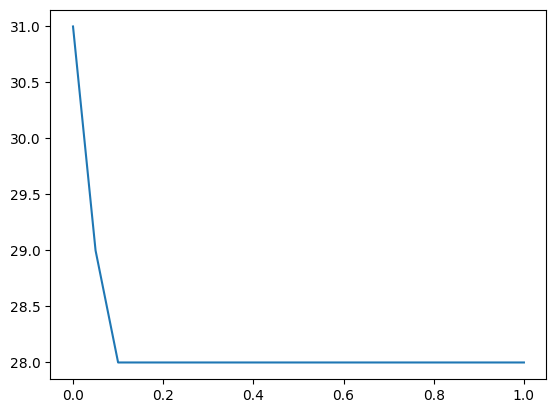

In [18]:
thresholds = np.arange(0.0, 1.05, 0.05)

# apply transform with each threshold
results = list()
for t in thresholds:
    # define the transform
    transform = VarianceThreshold(threshold=t)
    # transform the input data
    X_sel = transform.fit_transform(X_train_num)
    # determine the number of input features
    n_features = X_sel.shape[1]
    print(">Threshold=%.2f, Features=%d" % (t, n_features))
    # store the result
    results.append(n_features)
    # print(X_sel.dtype)

# plot the threshold vs the number of selected features
plt.plot(thresholds, results)
plt.show()

The line pot shows the relationship between the threshold and the number of features in the transformed dataset. I can see that with a small threshold of 0.10, 3 features are removed immediately.

First, we fit the estimator to data and call its get_support() method. It returns a boolean mask with True values for columns which are not dropped.

We can then use this mask to subset our DataFrame like so

In [19]:
_ = vt.fit(X_train_num)
mask = vt.get_support()

X_train_num = X_train_num.loc[:, mask]

# Let’s drop features with variances close to 0
vt = VarianceThreshold(threshold=1)

# Fit
_ = vt.fit(X_train_num)

# # Get the boolean mask
mask = vt.get_support()

X_train_LowVariance = X_train_num.loc[:, mask]

df_details("After dropping features with variances close to 0", X_train_LowVariance)
print("\nAfter dropping features with variances close to 0:\n")
print("Total number of observations: ", X_train_LowVariance.shape[0])
print("Total number of attributes: ", X_train_LowVariance.shape[1])
print("Size: ", X_train_LowVariance.size)
print("\n")
X_train_LowVariance.info()


| After dropping features with variances close to 0 | |
| --- | ---: |
| Number of observations | 168149 |
| Number of attributes | 28 |
| Size | 4708172 |


INFO:pycodestyle:17:80: E501 line too long (84 > 79 characters)



After dropping features with variances close to 0:

Total number of observations:  168149
Total number of attributes:  28
Size:  4708172


<class 'pandas.core.frame.DataFrame'>
Index: 168149 entries, 150503 to 32276
Data columns (total 28 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   new_cases                              168149 non-null  float64
 1   new_cases_smoothed                     168149 non-null  float64
 2   total_deaths                           168149 non-null  float64
 3   new_deaths                             168149 non-null  float64
 4   new_deaths_smoothed                    168149 non-null  float64
 5   total_cases_per_million                168149 non-null  float64
 6   new_cases_per_million                  168149 non-null  float64
 7   new_cases_smoothed_per_million         168149 non-null  float64
 8   total_deaths_per_million               168149 non-null 

The attributes that were dropped are:
 - reproduction_rate
 - new_people_vaccinated_smoothed_per_hundred
 - human_development_index

#### Method of normalizing all features by dividing them by their mean

In [20]:
normalized_df = X_train_LowVariance / X_train_LowVariance.mean()
normalized_df.head()

print("Variance of the normalized dataset:\n")
normalized_df.var()

,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_thousand,life_expectancy,population
150503,0.005559,0.000784,0.034631,0.081561,0.011501,0.426917,0.122803,0.017629,1.195671,2.480739,...,1.164111,0.438320,1.000000,0.786696,1.333934,0.499254,0.871915,0.565370,1.011032,0.020845
188994,0.000000,0.010197,0.000648,0.000000,0.011501,0.207387,0.000000,1.763253,0.172084,0.000000,...,2.285046,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.120594,0.002710
96728,245.319608,52.970809,17.861465,55.344995,18.573716,1.900248,20.571080,4.519719,2.341026,6.389206,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.491185
132111,4.537885,6.476861,15.877221,6.466626,8.531914,0.497367,0.226639,0.329152,1.239422,0.444850,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.219569
137661,0.000000,0.009682,0.000334,0.000000,0.000000,0.304929,0.000000,1.649975,0.087368,0.000000,...,1.677304,2.486636,0.014416,0.449430,0.627942,1.347045,0.463395,0.967781,1.126703,0.002749


Variance of the normalized dataset:



new_cases                                116.820790
new_cases_smoothed                        84.209544
total_deaths                              21.831489
new_deaths                                50.478200
new_deaths_smoothed                       42.709745
total_cases_per_million                    1.566082
new_cases_per_million                     59.102813
new_cases_smoothed_per_million            14.230405
total_deaths_per_million                   1.154105
new_deaths_per_million                    32.496046
new_deaths_smoothed_per_million            8.690622
new_vaccinations_smoothed                 28.511519
new_vaccinations_smoothed_per_million      1.872396
new_people_vaccinated_smoothed            34.614832
stringency_index                           0.170828
population_density                        18.324317
median_age                                 0.072375
aged_65_older                              0.390604
aged_70_older                              0.463001
gdp_per_capi

Now, I can use the estimator with a lower threshold like 0.05.

In [21]:
vt = VarianceThreshold(threshold=0.05)

# Fit
_ = vt.fit(normalized_df)

# # Get the boolean mask
mask = vt.get_support()

X_train_LowVariance_norm = X_train_LowVariance.loc[:, mask]

X_train_LowVariance_norm.shape

X_train_LowVariance_norm.info()

(168149, 27)

<class 'pandas.core.frame.DataFrame'>
Index: 168149 entries, 150503 to 32276
Data columns (total 27 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   new_cases                              168149 non-null  float64
 1   new_cases_smoothed                     168149 non-null  float64
 2   total_deaths                           168149 non-null  float64
 3   new_deaths                             168149 non-null  float64
 4   new_deaths_smoothed                    168149 non-null  float64
 5   total_cases_per_million                168149 non-null  float64
 6   new_cases_per_million                  168149 non-null  float64
 7   new_cases_smoothed_per_million         168149 non-null  float64
 8   total_deaths_per_million               168149 non-null  float64
 9   new_deaths_per_million                 168149 non-null  float64
 10  new_deaths_smoothed_per_million        168149 non-null  f

With a threshold of 0.05, life_expectancy attribute was removed.

I will check if it is appropriate to removed these 4 attributes. I will test this by training two RandomForestRegressor to predict a total_cases.

In [22]:
# Find out number of columns
d_x = X_train_LowVariance_norm.shape[1]
d_y = y_train.shape[1]

# Build feature, target arrays
X_validation, y_validation = (
    X_train_LowVariance_norm.iloc[:, [i for i in range(d_x)]],
    y_train.iloc[:, [j for j in range(d_y)]],
)

# Train/validation split
(
    X_train_validation,
    X_test_validation,
    y_train_validation,
    y_test_validation,
) = train_test_split(X_validation, y_validation, test_size=0.3, random_state=1121218)

# Init, fit, score
forest = RandomForestRegressor(random_state=1121218)

_ = forest.fit(X_train_validation, y_train_validation)

# Training Score
print(f"Training Score: {forest.score(X_train_validation, y_train_validation)}")

print(f"Test Score: {forest.score(X_test_validation, y_test_validation)}")

Training Score: 0.9999899458098208


INFO:pycodestyle:17:80: E501 line too long (85 > 79 characters)
INFO:pycodestyle:25:80: E501 line too long (80 > 79 characters)


Test Score: 0.999943230407504


Both training and test score suggest a really high performance without overfitting:
- Training Score: 0.9999899458098208
- Test Score: 0.999943230407504

Now, let’s train the same model on the full numeric-only dataset.

In [23]:
# Find out number of columns
d_x = X_train_num.shape[1]


# Build feature, target arrays
X_validation, y_validation = (
    X_train_num.iloc[:, [i for i in range(d_x)]],
    y_train.iloc[:, [j for j in range(d_y)]],
)

# Train/validation split
(
    X_train_validation,
    X_test_validation,
    y_train_validation,
    y_test_validation,
) = train_test_split(X_validation, y_validation, test_size=0.3, random_state=1121218)

# Init, fit, score
forest = RandomForestRegressor(random_state=1121218)

_ = forest.fit(X_train_validation, y_train_validation)

# Training Score
print(f"Training Score: {forest.score(X_train_validation, y_train_validation)}")

print(f"Test Score: {forest.score(X_test_validation, y_test_validation)}")

Training Score: 0.9999912300619879


INFO:pycodestyle:17:80: E501 line too long (85 > 79 characters)
INFO:pycodestyle:25:80: E501 line too long (80 > 79 characters)


Test Score: 0.9999449374508255


I can confirm that there isn't any impact on the prediction by removing these 4 features:
- Training Score: 0.9999912300619879
- Test Score: 0.9999449374508255

In [24]:
# Freeing memory
del X_validation
del y_validation
del X_train_validation
del y_train_validation
del X_test_validation
del y_test_validation

Drop the columns identified with variance close to 0:
- reproduction_rate
- new_people_vaccinated_smoothed_per_hundred
- human_development_index
- life_expectancy

In [25]:
X_train = X_train_NaN.drop(
    [
        "reproduction_rate",
        "new_people_vaccinated_smoothed_per_hundred",
        "human_development_index",
        "life_expectancy",
    ],
    axis=1,
)
df_details("After removing columns identified with variance close to 0", X_train)
print("After removing columns identified with variance close to 0:\n")
print("Total number of observations: ", X_train.shape[0])
print("Total number of attributes: ", X_train.shape[1])
print("Size: ", X_train.size)
print("\n")
X_train.info()


| After removing columns identified with variance close to 0 | |
| --- | ---: |
| Number of observations | 168149 |
| Number of attributes | 31 |
| Size | 5212619 |


After removing columns identified with variance close to 0:

Total number of observations:  168149
Total number of attributes:  31
Size:  5212619


<class 'pandas.core.frame.DataFrame'>
Index: 168149 entries, 150503 to 32276
Data columns (total 31 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   iso_code                               168149 non-null  object 
 1   continent                              159699 non-null  object 
 2   location                               168149 non-null  object 
 3   date                                   168149 non-null  object 
 4   new_cases                              168015 non-null  float64
 5   new_cases_smoothed                     168015 non-null  float64
 6   total_deaths                           161662 non-null  float64
 7   new_deaths                             168017 non-null  float64
 8   new_deaths_smoothed                    168017 n

INFO:pycodestyle:10:80: E501 line too long (81 > 79 characters)


### Delete Rows That Contain Duplicate Data
Rows that have identical data are could be useless to the modeling process, if not dangerously misleading during model evaluation. Here I check for any data duplication in the dataset.

In [26]:
# calculate duplicates
dups = X_train.duplicated()
# report if there are any duplicates
print(dups.any())
# list all duplicate rows
print(X_train[dups])

False
Empty DataFrame
Columns: [iso_code, continent, location, date, new_cases, new_cases_smoothed, total_deaths, new_deaths, new_deaths_smoothed, total_cases_per_million, new_cases_per_million, new_cases_smoothed_per_million, total_deaths_per_million, new_deaths_per_million, new_deaths_smoothed_per_million, new_vaccinations_smoothed, new_vaccinations_smoothed_per_million, new_people_vaccinated_smoothed, stringency_index, population_density, median_age, aged_65_older, aged_70_older, gdp_per_capita, extreme_poverty, cardiovasc_death_rate, diabetes_prevalence, female_smokers, male_smokers, hospital_beds_per_thousand, population]
Index: []

[0 rows x 31 columns]


Dataset doesn't contain any duplicate rows

### High correlation with other data columns

* https://www.kaggle.com/code/bbloggsbott/feature-selection-correlation-and-p-value

#### Select columns based on correlation

Dataset copy to be use in the correlation, remove the column total_cases because it is the column we are trying to predict

,iso_code,continent,location,date,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_thousand,population
iso_code,1.000000,0.047923,0.823763,0.009100,0.041219,0.049059,0.114369,0.073605,0.080341,-0.109911,...,-0.102731,-0.115128,-0.078225,0.076912,0.120919,0.060457,-0.095328,0.011580,-0.036584,0.087900
continent,0.047923,1.000000,-0.017049,0.017661,0.159278,0.188762,0.388771,0.253230,0.275586,0.187079,...,0.362225,0.342111,0.173838,-0.484724,-0.179192,0.394877,0.374574,-0.058535,0.118296,0.324403
location,0.823763,-0.017049,1.000000,0.011830,0.025220,0.030000,0.106015,0.063568,0.069063,-0.052053,...,-0.026745,-0.036806,0.036399,0.044502,0.077201,0.050344,-0.048116,0.035273,0.001756,0.039541
date,0.009100,0.017661,0.011830,1.000000,-0.022488,-0.025529,0.043431,-0.113866,-0.122890,0.423977,...,-0.002268,-0.002042,-0.008426,-0.005511,0.007056,0.025540,0.014354,0.011652,0.006472,-0.003535
new_cases,0.041219,0.159278,0.025220,-0.022488,1.000000,0.836514,0.409173,0.517474,0.435319,-0.008012,...,0.033682,0.031876,0.015449,-0.028206,-0.031256,-0.002710,-0.002947,0.010377,0.021714,0.388911
new_cases_smoothed,0.049059,0.188762,0.030000,-0.025529,0.836514,1.000000,0.485733,0.496173,0.524383,-0.007891,...,0.035804,0.033671,0.016144,-0.030408,-0.033614,-0.002733,-0.004446,0.011500,0.022940,0.457132
total_deaths,0.114369,0.388771,0.106015,0.043431,0.409173,0.485733,1.000000,0.498379,0.545193,-0.001687,...,0.035994,0.032949,0.011452,-0.051419,-0.044354,0.003480,-0.007953,-0.000957,-0.002450,0.835034
new_deaths,0.073605,0.253230,0.063568,-0.113866,0.517474,0.496173,0.498379,1.000000,0.922427,-0.048445,...,0.029564,0.027087,0.010470,-0.037825,-0.031133,-0.001563,-0.004467,0.004405,0.004586,0.575160
new_deaths_smoothed,0.080341,0.275586,0.069063,-0.122890,0.435319,0.524383,0.545193,0.922427,1.000000,-0.052051,...,0.030942,0.028276,0.010623,-0.039822,-0.032078,-0.001598,-0.005233,0.004813,0.004917,0.625520
total_cases_per_million,-0.109911,0.187079,-0.052053,0.423977,-0.008012,-0.007891,-0.001687,-0.048445,-0.052051,1.000000,...,0.569616,0.564620,0.502088,-0.417051,-0.316214,0.084020,0.487237,0.063665,0.363407,-0.082819


<Axes: >

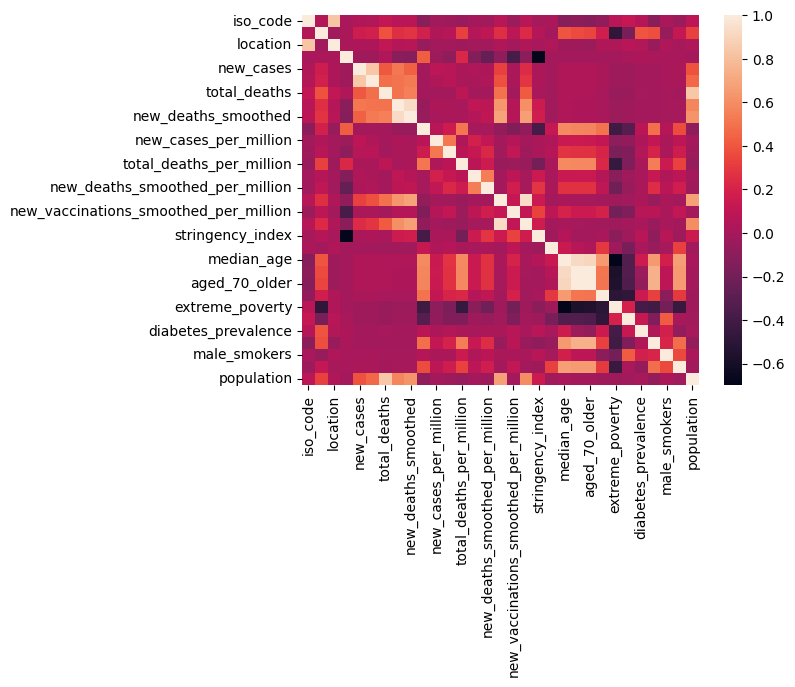

INFO:pycodestyle:3:80: E501 line too long (94 > 79 characters)
INFO:pycodestyle:13:80: E501 line too long (82 > 79 characters)


In [27]:
X_train_data_corr = X_train.copy()

# The numpy.random.seed() makes the random numbers predictable and is used for reproducibility
np.random.seed(123)

# Find out the index for categorical variables
continent = X_train_data_corr.columns.get_loc("continent")
location = X_train_data_corr.columns.get_loc("location")
iso_code = X_train_data_corr.columns.get_loc("iso_code")
date = X_train_data_corr.columns.get_loc("date")

# Encode the Categorical Variable
# The dataset has 4 categorical attributes: date, continent, iso_code and location
label_encoder = LabelEncoder()
X_train_data_corr.iloc[:, continent] = label_encoder.fit_transform(
    X_train_data_corr.iloc[:, continent]
).astype("float64")
X_train_data_corr.iloc[:, location] = label_encoder.fit_transform(
    X_train_data_corr.iloc[:, location]
).astype("float64")
X_train_data_corr.iloc[:, iso_code] = label_encoder.fit_transform(
    X_train_data_corr.iloc[:, iso_code]
).astype("float64")
X_train_data_corr.iloc[:, date] = label_encoder.fit_transform(
    X_train_data_corr.iloc[:, date]
).astype("float64")

corr = X_train_data_corr.corr()
corr

sns.heatmap(corr)

Next, compare the correlation between features and remove one of two features that have a correlation higher than 0.9.

In [28]:
columns = np.full((corr.shape[0],), True, dtype=bool)
columns
selected_columns = X_train_data_corr.columns[columns]
selected_columns

for i in range(corr.shape[0]):
    for j in range(i + 1, corr.shape[0]):
        if corr.iloc[i, j] >= 0.9:
            if columns[j]:
                columns[j] = False

columns
selected_columns = X_train_data_corr.columns[columns]
# selected_columns
# selected_columns.shape

selected_columns
selected_columns.shape

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

Index(['iso_code', 'continent', 'location', 'date', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'new_vaccinations_smoothed',
       'new_vaccinations_smoothed_per_million',
       'new_people_vaccinated_smoothed', 'stringency_index',
       'population_density', 'median_age', 'aged_65_older', 'aged_70_older',
       'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate',
       'diabetes_prevalence', 'female_smokers', 'male_smokers',
       'hospital_beds_per_thousand', 'population'],
      dtype='object')

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True, False, False,  True,  True,  True,  True,
        True,  True,  True,  True])

Index(['iso_code', 'continent', 'location', 'date', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'total_cases_per_million', 'new_cases_per_million',
       'new_cases_smoothed_per_million', 'total_deaths_per_million',
       'new_deaths_per_million', 'new_deaths_smoothed_per_million',
       'new_vaccinations_smoothed', 'new_vaccinations_smoothed_per_million',
       'stringency_index', 'population_density', 'median_age',
       'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate',
       'diabetes_prevalence', 'female_smokers', 'male_smokers',
       'hospital_beds_per_thousand', 'population'],
      dtype='object')

(27,)

Correlation between features correlation higher than 0.9 are:
- 'new_deaths_smoothed'
- 'new_people_vaccinated_smoothed'
- 'aged_65_older'
- 'aged_70_older'

Remove the four features that have a correlation higher than 0.9

In [29]:
X_train = X_train_data_corr[selected_columns]

df_details("After removing features that have a correlation higher than 0.9", X_train)
print("After removing features that have a correlation higher than 0.9\n")
print("Total number of observations: ", X_train.shape[0])
print("Total number of attributes: ", X_train.shape[1])
print("Size: ", X_train.size)
print("\n")
X_train.info()


| After removing features that have a correlation higher than 0.9 | |
| --- | ---: |
| Number of observations | 168149 |
| Number of attributes | 27 |
| Size | 4540023 |


INFO:pycodestyle:3:80: E501 line too long (86 > 79 characters)


After removing features that have a correlation higher than 0.9

Total number of observations:  168149
Total number of attributes:  27
Size:  4540023


<class 'pandas.core.frame.DataFrame'>
Index: 168149 entries, 150503 to 32276
Data columns (total 27 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   iso_code                               168149 non-null  object 
 1   continent                              168149 non-null  object 
 2   location                               168149 non-null  object 
 3   date                                   168149 non-null  object 
 4   new_cases                              168015 non-null  float64
 5   new_cases_smoothed                     168015 non-null  float64
 6   total_deaths                           161662 non-null  float64
 7   new_deaths                             168017 non-null  float64
 8   total_cases_per_million                1681

### Select columns based on p-value

Select the columns based on how they affect the p-value.

In [30]:
X_train_p_value = X_train.copy()

# Take care of missing values encoded as NaN natively by replacing with the mean

for c in X_train_p_value.columns:
    X_train_p_value[c] = X_train_p_value[c].fillna(X_train_p_value[c].mean())

INFO:pycodestyle:3:80: E501 line too long (80 > 79 characters)


TODO: Function documentation

In [31]:
def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    # x=np.array(x, dtype=float)
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if regressor_OLS.pvalues[j].astype(float) == maxVar:
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)

    return x, columns, regressor_OLS.summary()

TODO

In [32]:
SL = 0.05
data_modeled, selected_columns, summary = backwardElimination(
    X_train_p_value.iloc[:, :].values, y_train.iloc[:, :].values, SL, selected_columns
)

INFO:pycodestyle:3:80: E501 line too long (86 > 79 characters)


TODO

In [33]:
summary

data = pd.DataFrame(data=data_modeled, columns=selected_columns)

data.head()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.931
Model:                            OLS   Adj. R-squared (uncentered):              0.931
Method:                 Least Squares   F-statistic:                          9.817e+04
Date:                Mon, 06 Nov 2023   Prob (F-statistic):                        0.00
Time:                        08:46:05   Log-Likelihood:                     -2.9818e+06
No. Observations:              168149   AIC:                                  5.964e+06
Df Residuals:                  168126   BIC:                                  5.964e+06
Df Model:                          23                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          4.151e+04    768.406     54.025      0.000       4e+04     4.3e+04
x2         -9.556e+05   2.08e+04    -45.875      0.000   -9.96e+05   -9.15e+05
x3         -5.604e+04    775.881    -72.233      0.000   -5.76e+04   -5.45e+04
x4          2196.6182    119.115     18.441      0.000    1963.155    2430.082
x5             9.9061      0.430     23.026      0.000       9.063      10.749
x6             1.6996      0.509      3.340      0.001       0.702       2.697
x7            95.8559      0.127    755.357      0.000      95.607      96.105
x8         -8724.4505     72.062   -121.068      0.000   -8865.691   -8583.210
x9            17.2635      0.266     64.816      0.000      16.742      17.786
x10         -215.2473     43.252     -4.977      0.000    -300.021    -130.473
x11        -2184.5881     37.013    -59.022      0.000   -2257.133   -2112.043
x12         6.281e+04   6219.169     10.100      0.000    5.06e+04     7.5e+04
x13         6.284e+04   1.28e+04      4.928      0.000    3.78e+04    8.78e+04
x14           -4.8034      0.026   -183.677      0.000      -4.855      -4.752
x15           44.9545     12.563      3.578      0.000      20.330      69.579
x16         1.828e+04   1940.270      9.421      0.000    1.45e+04    2.21e+04
x17         -225.7139     23.047     -9.794      0.000    -270.885    -180.543
x18         7.764e+04   5244.366     14.805      0.000    6.74e+04    8.79e+04
x19          -23.7412      2.453     -9.678      0.000     -28.549     -18.933
x20        -1.347e+04   2205.501     -6.109      0.000   -1.78e+04   -9151.225
x21        -4257.9557    287.760    -14.797      0.000   -4821.960   -3693.952
x22         3.642e+05   1.89e+04     19.260      0.000    3.27e+05    4.01e+05
x23            0.0070   9.97e-05     70.061      0.000       0.007       0.007
==============================================================================
Omnibus:                   127137.718   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         18003914.269
Skew:                           2.828   Prob(JB):                         0.00
Kurtosis:                      53.376   Cond. No.                     5.04e+08
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 5.04e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,iso_code,continent,location,date,new_cases,new_cases_smoothed,total_deaths,new_deaths,total_cases_per_million,new_cases_smoothed_per_million,...,new_vaccinations_smoothed,new_vaccinations_smoothed_per_million,stringency_index,population_density,median_age,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,hospital_beds_per_thousand,population
0,102.0,3.0,107.0,810.0,67.0,9.571,3528.0,7.0,54657.630,3.385,...,1.550000e+02,55.000000,38.777144,266.879000,31.400000,8193.571000,13.87359,206.537000,1.70000,2.827382e+06
1,143.0,3.0,135.0,110.0,0.0,124.429,66.0,0.0,26551.514,338.570,...,3.231446e+05,1897.367888,38.777144,326.282379,45.700000,18693.106291,13.87359,262.537128,3.00688,3.675120e+05
2,163.0,6.0,69.0,457.0,2956560.0,646381.857,1819629.0,4750.0,243286.033,867.851,...,5.590850e+05,751.000000,38.777144,326.282379,30.387504,18693.106291,13.87359,262.537128,3.00688,7.448078e+08
3,164.0,6.0,95.0,186.0,54690.0,79034.571,1617485.0,555.0,63677.243,63.202,...,7.606452e+06,6083.000000,38.777144,326.282379,30.387504,18693.106291,13.87359,262.537128,3.00688,1.250515e+09
4,99.0,2.0,98.0,311.0,0.0,118.143,34.0,0.0,39039.643,316.819,...,8.210000e+02,2202.000000,27.780000,3.404000,37.300000,46482.958000,0.20000,117.992000,2.91000,3.729030e+05


TODO

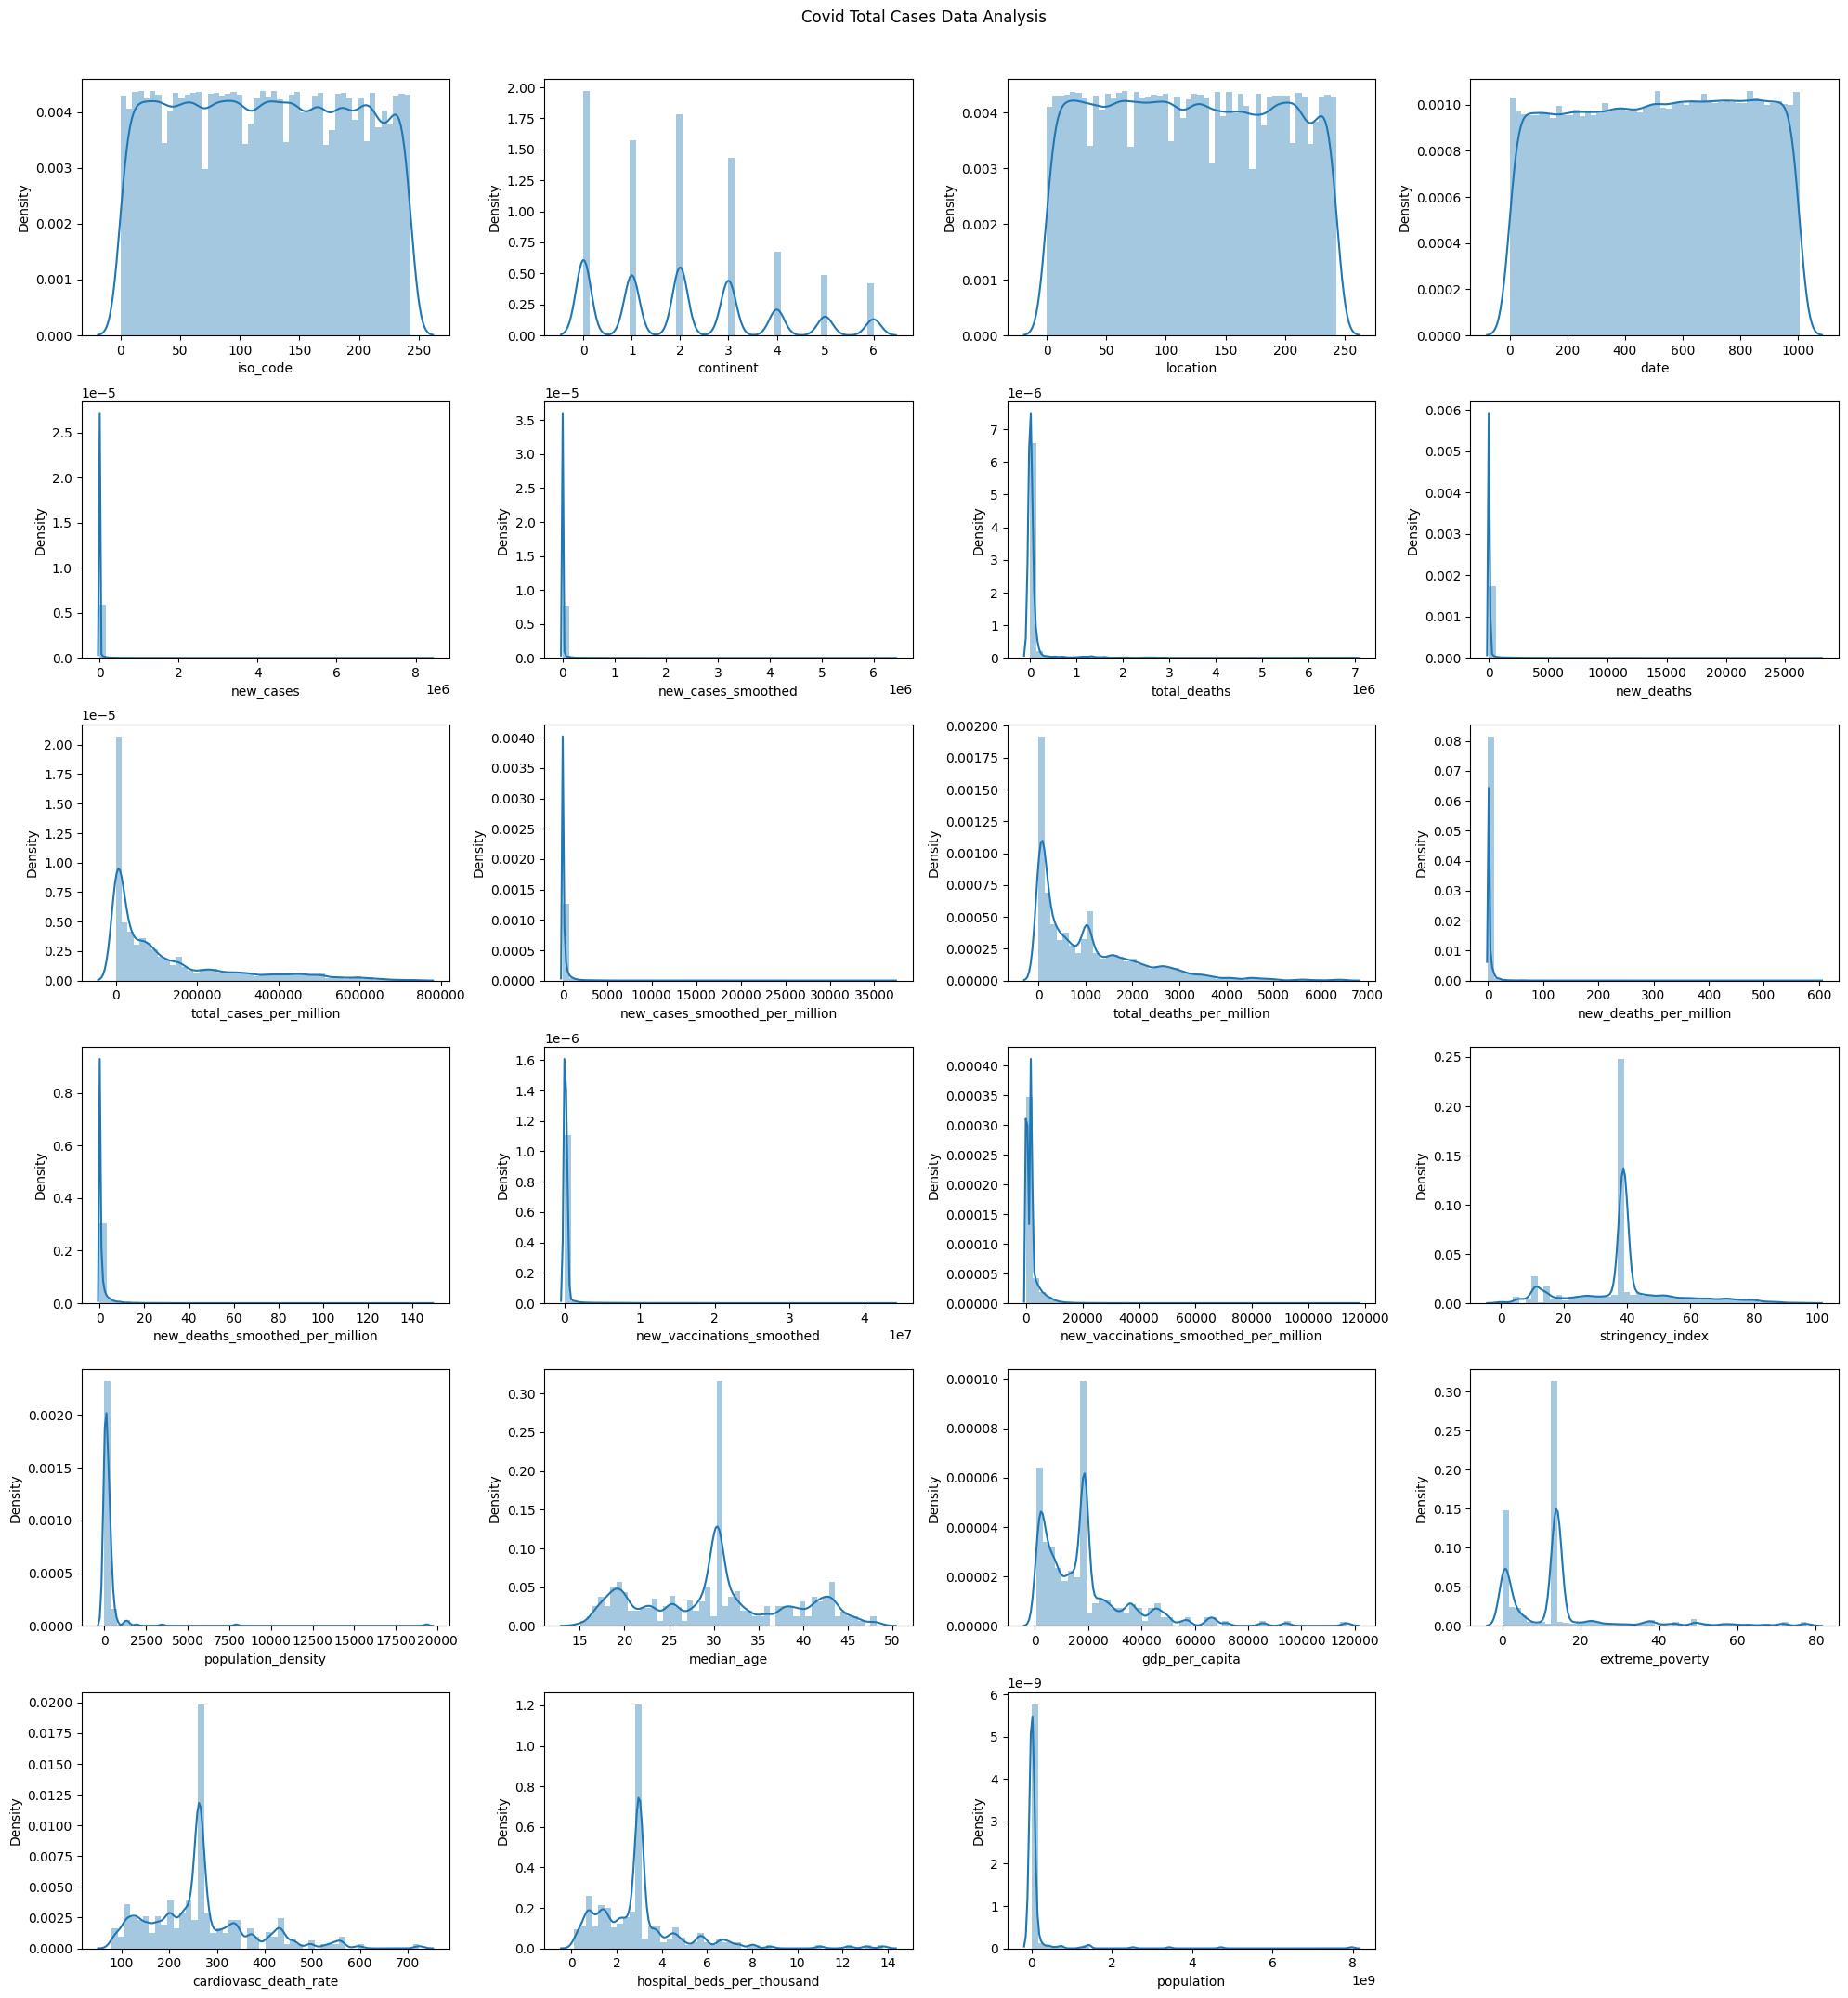

INFO:pycodestyle:13:11: E703 statement ends with a semicolon


In [34]:
fig = plt.figure(figsize=(20, 25))
j = 0
for i in data.columns:
    plt.subplot(7, 4, j + 1)
    j += 1
    sns.distplot(data[i])
    # plt.legend(loc='best',fontsize=10)
fig.suptitle("Covid Total Cases Data Analysis")
fig.tight_layout()
fig.subplots_adjust(top=0.95)


plt.show();

TODO

In [35]:
df_details("After removing columns based on how they affect the p-value", data)
print("After removing columns based on how they affect the p-value.:\n")
print("Total number of observations: ", data.shape[0])
print("Total number of attributes: ", data.shape[1])
print("Size: ", data.size)
print("\n")
data.info()


| After removing columns based on how they affect the p-value | |
| --- | ---: |
| Number of observations | 168149 |
| Number of attributes | 23 |
| Size | 3867427 |


After removing columns based on how they affect the p-value.:

Total number of observations:  168149
Total number of attributes:  23
Size:  3867427


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168149 entries, 0 to 168148
Data columns (total 23 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   iso_code                               168149 non-null  float64
 1   continent                              168149 non-null  float64
 2   location                               168149 non-null  float64
 3   date                                   168149 non-null  float64
 4   new_cases                              168149 non-null  float64
 5   new_cases_smoothed                     168149 non-null  float64
 6   total_deaths                           168149 non-null  float64
 7   new_deaths                             168149 non-null  float64
 8   total_cases_per_million                16814

# Generate Profiling Report

In [36]:
# Generate profiling report
# profile = ProfileReport(data, title="Profiling Report", html={'style':{'fullwith':True}})
# profile

INFO:pycodestyle:2:80: E501 line too long (91 > 79 characters)
